In [3]:
!pip install llama_index==0.9.31 pypdf python-dotenv matplotlib

You should consider upgrading via the 'C:\llamaindex\llamaindex-samples\llamaindex\Scripts\python.exe -m pip install --upgrade pip' command.


## Load document

In [4]:
import os, logging, sys
import nest_asyncio
from IPython.lib.pretty import pretty

nest_asyncio.apply()
from dotenv import load_dotenv 

load_dotenv(".env", override=True)
openai_key = os.environ["OPENAI_API_KEY"] 

logging.basicConfig(stream=sys.stdout, level=logging.CRITICAL)

In [5]:
# from llama_index.core import SimpleDirectoryReader
# from llama_index.core.indices.service_context import ServiceContext
from llama_index import SimpleDirectoryReader
from llama_index import ServiceContext
from llama_index.llms.openai import OpenAI
from llama_index.node_parser import SentenceSplitter

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

documents = SimpleDirectoryReader("data_eval").load_data()
print(f"loaded documents with {len(documents)} documents")


node_parser = SentenceSplitter(chunk_size=256)
nodes = node_parser(documents)
print(f"loaded {len(nodes)} nodes")

loaded documents with 8 documents
loaded 16 nodes


In [7]:
nodes[:8]

[TextNode(id_='4ce5e3ea-8601-4f49-81b5-724ff93d8f66', embedding=None, metadata={'page_label': '1', 'file_name': 'DevOps_Self-Service_Pipeline_Architecture.pdf', 'file_path': 'data_eval\\DevOps_Self-Service_Pipeline_Architecture.pdf', 'file_type': 'application/pdf', 'file_size': 771061, 'creation_date': '2024-03-17', 'last_modified_date': '2024-03-17', 'last_accessed_date': '2024-03-19'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='56234f1e-31da-4574-bba8-c840cf9fdf26', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '1', 'file_name': 'DevOps_Self-Service_Pipeline_Architecture.pdf', 'file_path': 'data_eval\\DevOps_Self-Service_Pipeline_Architecture.pdf', 'file_type': 'application/pdf', 'fil

## Generate evaluation question/answer pairs

In [9]:
from llama_index.evaluation import (
    DatasetGenerator,
    QueryResponseDataset,
)

eval_service_context = ServiceContext.from_defaults(llm=OpenAI(model="gpt-4-1106-preview"))

# load eval question/answer dataset from JSON file if exists
if os.path.exists("data_eval/eval_qr_dataset.json"):
    eval_dataset = QueryResponseDataset.from_json("data_eval/eval_qr_dataset.json")
else:
    # construct dataset_generator
    dataset_generator = DatasetGenerator(
        nodes[:8],
        service_context=eval_service_context,
        show_progress=False,
        num_questions_per_chunk=2,
    )

    # generate queries and responses
    eval_dataset = dataset_generator.generate_dataset_from_nodes()

    # save the dataset into a file
    eval_dataset.save_json("data_eval/eval_qr_dataset.json")

c:\llamaindex\llamaindex-samples\llamaindex\lib\site-packages\llama_index\evaluation\dataset_generation.py:93: DeprecationWarning: Call to deprecated class QueryResponseDataset. (Deprecated in favor of `LabelledRagDataset` which should be used instead.)
  return cls(**data)


In [10]:
import json

# Load dataset from JSON file
with open("data_eval/eval_qr_dataset.json", "r") as file:
    eval_dataset_content = json.load(file)

# Print the content in JSON format
json_str = json.dumps(eval_dataset_content, indent=2)  # indent for pretty printing
print(json_str)

{
  "queries": {
    "74fa3b29-73ce-4837-a954-1bae16d932b6": "According to the document \"DevOps_Self-Service_Pipeline_Architecture.pdf,\" what is the primary goal of implementing a DevOps self-service approach, also referred to as democratizing DevOps or Platform Engineering?",
    "d34878ff-d267-4212-a115-9471e1bb1300": "In the context of the document provided, explain the significance of the \"3\u20132\u20131 Rule\" in relation to the DevOps Self-Service Pipeline Architecture.",
    "d3e688eb-6d2c-4a1e-a838-f5f711c64496": "Explain the 3-2-1 rule coined by the author in the context of the self-service pipeline architecture as described in the \"DevOps_Self-Service_Pipeline_Architecture.pdf\" document. Include in your answer the types of source code, pipelines, and the integration glue mentioned.",
    "2134acbc-5bb5-4cdc-9e77-21e0c8afde73": "Discuss the differences between the generic self-service pipeline architecture tailored for microservices and the architecture that should be us

In [11]:
eval_qs = eval_dataset.questions
ref_response_strs = [r for (_, r) in eval_dataset.qr_pairs]

## Build index, query engine, gather parameters

In [12]:
from llama_index import (
    VectorStoreIndex,
    load_index_from_storage,
    StorageContext,
    ServiceContext,
)
from llama_index.param_tuner.base import ParamTuner, TunedResult, RunResult
from llama_index.evaluation.eval_utils import get_responses
from llama_index.evaluation import SemanticSimilarityEvaluator, BatchEvalRunner

import os
import numpy as np
from pathlib import Path

def _build_index(chunk_size, docs):
    index_out_path = f"./storage_{chunk_size}"
    if not os.path.exists(index_out_path):
        Path(index_out_path).mkdir(parents=True, exist_ok=True)

        # Using the new flattened interface for node parsing
        node_parser = SentenceSplitter(chunk_size=chunk_size)
        nodes = node_parser(docs)

        # build index
        index = VectorStoreIndex(nodes)

        # save index to disk
        index.storage_context.persist(index_out_path)
    else:
        # rebuild storage context
        storage_context = StorageContext.from_defaults(
            persist_dir=index_out_path
        )
        # load index
        index = load_index_from_storage(
            storage_context,
        )
    return index

In [13]:
# contains the parameters that need to be tuned
param_dict = {"chunk_size": [256, 512], "top_k": [1, 2]}

# contains parameters remaining fixed across all runs of the tuning process
fixed_param_dict = {
    "docs": documents,
    "eval_qs": eval_qs,
    "ref_response_strs": ref_response_strs,
}

## Define EDD to measure the score for each parameter combination

In [14]:
def _get_eval_batch_runner_semantic_similarity():
    eval_service_context = ServiceContext.from_defaults(
        llm=OpenAI(model="gpt-4-1106-preview")
    )
    evaluator_s = SemanticSimilarityEvaluator(
        service_context=eval_service_context
    )
    eval_batch_runner = BatchEvalRunner(
        {"semantic_similarity": evaluator_s}, workers=2, show_progress=True
    )

    return eval_batch_runner


def objective_function_semantic_similarity(params_dict):
    chunk_size = params_dict["chunk_size"]
    docs = params_dict["docs"]
    top_k = params_dict["top_k"]
    eval_qs = params_dict["eval_qs"]
    ref_response_strs = params_dict["ref_response_strs"]

    # build index
    index = _build_index(chunk_size, docs)

    # query engine
    query_engine = index.as_query_engine(similarity_top_k=top_k)

    # get predicted responses
    pred_response_objs = get_responses(
        eval_qs, query_engine, show_progress=True
    )

    # run evaluator
    eval_batch_runner = _get_eval_batch_runner_semantic_similarity()
    eval_results = eval_batch_runner.evaluate_responses(
        eval_qs, responses=pred_response_objs, reference=ref_response_strs
    )

    # get semantic similarity metric
    mean_score = np.array(
        [r.score for r in eval_results["semantic_similarity"]]
    ).mean()

    return RunResult(score=mean_score, params=params_dict)

## Run Parameter Tuner

In [15]:
from llama_index.param_tuner import ParamTuner

param_tuner = ParamTuner(
    param_fn=objective_function_semantic_similarity,
    param_dict=param_dict,
    fixed_param_dict=fixed_param_dict,
    show_progress=True,
)

results = param_tuner.tune()

best_result = results.best_run_result
best_top_k = results.best_run_result.params["top_k"]
best_chunk_size = results.best_run_result.params["chunk_size"]

print("")
print(f"Semantic Similarity Score: {best_result.score}")
print(f"Top-k: {best_top_k}")
print(f"Chunk size: {best_chunk_size}")

c:\llamaindex\llamaindex-samples\llamaindex\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Param combinations.:   0%|          | 0/4 [00:00<?, ?it/s]

Param combinations.: 100%|██████████| 4/4 [00:40<00:00, 10.08s/it]


Semantic Similarity Score: 0.9582030574690956
Top-k: 2
Chunk size: 256


Score: 0.9582030574690956, Top_k: 2, Chunk_size: 256
Score: 0.9580475137577094, Top_k: 2, Chunk_size: 512
Score: 0.9576506629216948, Top_k: 1, Chunk_size: 256
Score: 0.9546194535263497, Top_k: 1, Chunk_size: 512


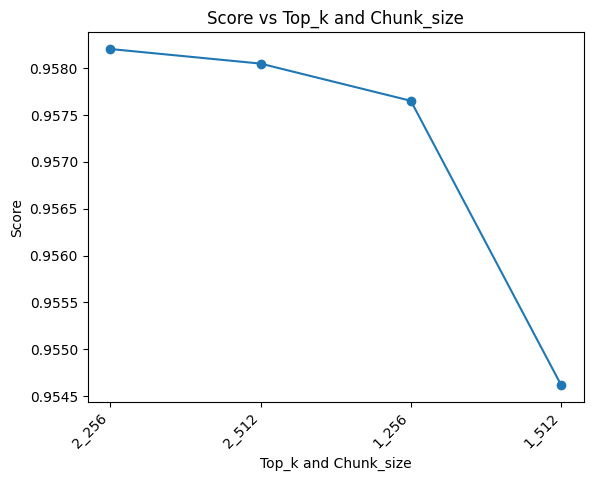

In [16]:
import matplotlib.pyplot as plt

# use the following lists to store data
scores = []
top_k_chunk_combos = []

for result in results.run_results:
    p = result.params
    score = result.score
    top_k = p["top_k"]
    chunk_size = p["chunk_size"]

    # Combine top_k and chunk_size for x-axis label
    top_k_chunk_combo = f"{top_k}_{chunk_size}"

    # Append values to the lists
    scores.append(score)
    top_k_chunk_combos.append(top_k_chunk_combo)

    print(f"Score: {score}, Top_k: {top_k}, Chunk_size: {chunk_size}")

# Create a line chart
plt.plot(top_k_chunk_combos, scores, marker='o', linestyle='-')
plt.xlabel('Top_k and Chunk_size')
plt.ylabel('Score')
plt.title('Score vs Top_k and Chunk_size')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.show()


Score: 0.9582030574690956, Top_k: 2, Chunk_size: 256
Score: 0.9580475137577094, Top_k: 2, Chunk_size: 512
Score: 0.9576506629216948, Top_k: 1, Chunk_size: 256
Score: 0.9546194535263497, Top_k: 1, Chunk_size: 512


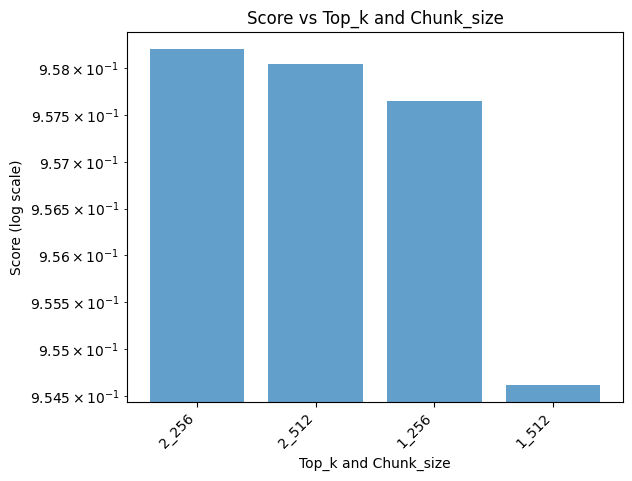

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# use the following lists to store data
scores = []
top_k_chunk_combos = []

for result in results.run_results:
    p = result.params
    score = result.score
    top_k = p["top_k"]
    chunk_size = p["chunk_size"]

    # Combine top_k and chunk_size for x-axis label
    top_k_chunk_combo = f"{top_k}_{chunk_size}"

    # Append values to the lists
    scores.append(score)
    top_k_chunk_combos.append(top_k_chunk_combo)

    print(f"Score: {score}, Top_k: {top_k}, Chunk_size: {chunk_size}")

# Create a bar chart with log scale for the y-axis
plt.bar(top_k_chunk_combos, scores, align='center', alpha=0.7)
plt.yscale('log')  # Set log scale for the y-axis
plt.xlabel('Top_k and Chunk_size')
plt.ylabel('Score (log scale)')
plt.title('Score vs Top_k and Chunk_size')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.show()
